# Guided Project: Time-Series Forecasting on the S&P 500

### *Lu Yang*
### 07-02-2023

## Introduction

In this guided project, we'll be taking on the role of a trader on the S&P 500 futures desk. Our goal is to build a successful model to forecast how this index will move based on its past behavior. If we can make successful predictions, we can trade these futures effectively and lucratively. Indeed we are learning data science "for fun and profit!"
![](https://s3.amazonaws.com/dq-content/790/stock-exchange-gec2cbec0e_640.jpg)


To get started, we'll first need to take a look at the dataset we'll be using. It's from [Yahoo Finance via Kaggle](https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price) and contains S&P 500 Index prices from 2015 through 2020. The file is stored in your workspace as `yahoo_stock.csv`.

## Data Wrangling and Exploration

The data has several potential columns for us to use for forecasting:

- `Open`: the opening value of the index on that day
- `High`: the highest value of the index on that day
- `Low`: the lowest value of the index on that day
- `Close`: the closing value of the index on that day
- `Volume`: the total volume of the index traded on that day
- `Adj Close`: the closing value of the index on that day adjusted for dividends

In [1]:
## general setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date

In [2]:
stock = pd.read_csv('yahoo_stock.csv', parse_dates = ['Date'])
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


In [4]:
stock.describe(include = 'all', datetime_is_numeric = True)

,Date,High,Low,Open,Close,Volume,Adj Close
count,1825,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2018-05-23 00:00:00,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
min,2015-11-23 00:00:00,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2017-02-21 00:00:00,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2018-05-23 00:00:00,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2019-08-22 00:00:00,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,2020-11-20 00:00:00,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912
std,NaN,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177


In [5]:
## check missing values - no missing values

stock.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [6]:
## check data - no duplicates

print(stock.shape, stock['Date'].value_counts().shape)

(1825, 7) (1825,)


In [7]:
## sort by date

stock.sort_values('Date', ascending = True, inplace = True)
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [8]:
## use adjusted closing value for prediction & date as index

stock = stock[['Date', 'Adj Close']]
stock.set_index('Date', inplace = True)

stock.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


**Upon data exploration, we found that:**
* No missing values existed in the data set. 
* The number of unique values for `Date` matched with the number of rows, so no duplicate date values.
* We will be using `Adj Close` column for prediction and set `Date` as the index.

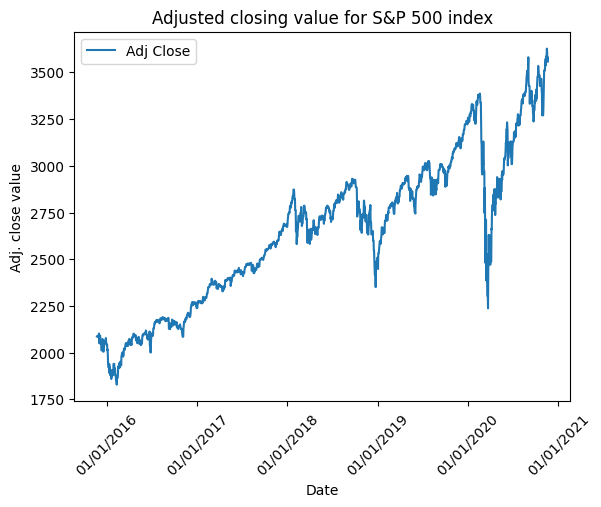

In [9]:
## Visualize Adj Close

sns.lineplot(data = stock).set(
    title = 'Adjusted closing value for S&P 500 index',
    xlabel = 'Date', 
    ylabel = 'Adj. close value'
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation = 45)
plt.show()

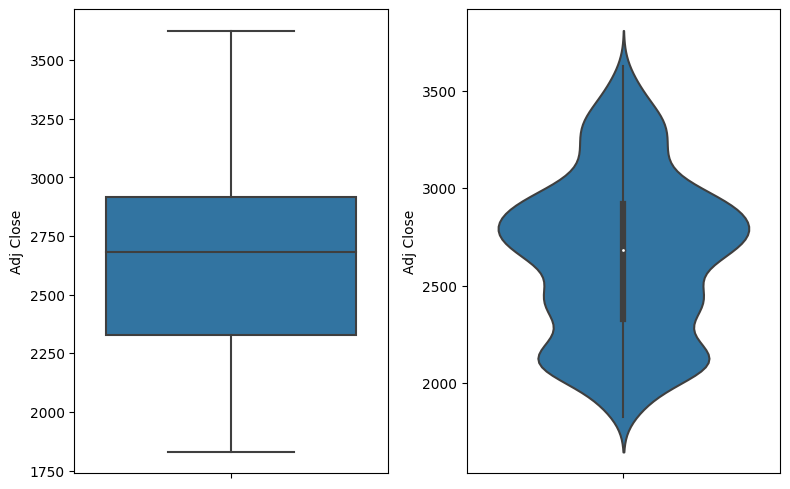

In [10]:
plt.figure(figsize = (8, 5))

plt.subplot(1,2,1)
sns.boxplot(data = stock, y = 'Adj Close')

plt.subplot(1,2,2)
sns.violinplot(data = stock, y = 'Adj Close')

plt.tight_layout()

There was no obvious evidence for the presence of outliers in the `Adj Close` data column.

## Data Preprocessing

In [11]:
## Use a 60-20-20 split

train_size = round(0.6 * len(stock))
validation_size = round(0.2 * len(stock))

print(train_size, validation_size)

1095 365


In [12]:
train = stock.iloc[:train_size]
validation = stock.iloc[train_size:train_size + validation_size]
test = stock.iloc[train_size + validation_size:]

print(f'train size: {train.shape}, validation size: {validation.shape}, test size: {test.shape}')

train size: (1095, 1), validation size: (365, 1), test size: (365, 1)


In [13]:
## scikit learn setup
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

scaler.fit(train)

train_scaled = scaler.transform(train)
validation_scaled = scaler.transform(validation)
test_scaled = scaler.transform(test)

In [15]:
def create_dataset_by_windowing(data: np.ndarray, window = 1):
    
    X = []
    y = []
    
    for i in range(len(data) - window):
        
        Xi = data[i : i + window]
        yi = data[i + window]
        X.append(Xi)
        y.append(yi)
    
    return np.array(X), np.array(y)

In [16]:
window = 5

X_train, y_train = create_dataset_by_windowing(train_scaled, window = window)
X_val, y_val = create_dataset_by_windowing(validation_scaled, window = window)
X_test, y_test = create_dataset_by_windowing(test_scaled, window = window)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1090, 1, 5) (1090, 1)
(360, 1, 5) (360, 1)
(360, 1, 5) (360, 1)


## Build and Train a Basic RNN Model

In [19]:
## tensorflow setup

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import r2_score

tf.keras.utils.set_random_seed(123)

In [20]:
## Exp w/ SimpleRNN

model = Sequential()

model.add(SimpleRNN(16, input_shape = (1, window), activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                352       
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 1s 2ms/step - loss: 0.0695
Epoch 2/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 3/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 4/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 7.0194e-04
Epoch 6/10
35/35 [==============================] - 0s 2ms/step - loss: 4.2175e-04
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 3.9035e-04
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 3.9485e-04
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 3.5501e-04
Epoch 10/10
35/35 [==============================] - 0s 2ms/step - loss: 3.1771e-04


In [22]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Training R2 score {r2_score(y_train, y_train_pred)}\nValidation R2 score {r2_score(y_val, y_val_pred)}')

12/12 [==============================] - 0s 1ms/step
Training R2 score 0.9956329884957169
Validation R2 score 0.9679143343276883


## Build and Train an LSTM Model

In [23]:
## Exp w/ LSTM

model = Sequential()

model.add(LSTM(16, input_shape = (1, window)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1408      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 2s 3ms/step - loss: 0.1736
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 3/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 4/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/10
35/35 [==============================] - 0s 2ms/step - loss: 5.1123e-04
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 4.0333e-04
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 4.0012e-04
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 3.8326e-04
Epoch 10/10
35/35 [==============================] - 0s 2ms/step - loss: 3.7711e-04


In [25]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Training R2 score {r2_score(y_train, y_train_pred)}\nValidation R2 score {r2_score(y_val, y_val_pred)}')

12/12 [==============================] - 0s 1ms/step
Training R2 score 0.9946273822858619
Validation R2 score 0.9610035920931641


## Add a Convolutional Layer

In [26]:
## Exp w/ LSTM + conv1D

model = Sequential()

model.add(Conv1D(32, 1, input_shape = (1, window), activation = 'relu'))
model.add(MaxPool1D(1))  ## no impact
model.add(LSTM(16))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
____________________________________________________

In [27]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 2s 3ms/step - loss: 0.1787
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 3/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 3.9254e-04
Epoch 6/10
35/35 [==============================] - 0s 2ms/step - loss: 3.7266e-04
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 3.6046e-04
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 3.7950e-04
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 3.6108e-04
Epoch 10/10
35/35 [==============================] - 0s 2ms/step - loss: 3.4277e-04


In [28]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Training R2 score {r2_score(y_train, y_train_pred)}\nValidation R2 score {r2_score(y_val, y_val_pred)}')

12/12 [==============================] - 0s 2ms/step
Training R2 score 0.9949936976928738
Validation R2 score 0.9628945780165544


## Optimize the Model

In [29]:
## Choose LSTM model w/o conv layer

model = Sequential()

model.add(LSTM(32, input_shape = (1, window)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4864      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 2s 3ms/step - loss: 0.1525
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 3/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 6/10
35/35 [==============================] - 0s 2ms/step - loss: 7.9373e-04
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 6.6444e-04
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 5.9698e-04
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 5.4022e-04
Epoch 10/10
35/35 [==============================] - 0s 2ms/step - loss: 5.1348e-04


In [31]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f'Training R2 score {r2_score(y_train, y_train_pred)}\nValidation R2 score {r2_score(y_val, y_val_pred)}')

12/12 [==============================] - 0s 1ms/step
Training R2 score 0.992816281258241
Validation R2 score 0.9552803358511189


## Evaluate Model Performance

In [32]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print(f'Training R2 score {r2_score(y_train, y_train_pred)}\nValidation R2 score {r2_score(y_val, y_val_pred)}\n\
Testing R2 score {r2_score(y_test, y_test_pred)}')

12/12 [==============================] - 0s 2ms/step
Training R2 score 0.992816281258241
Validation R2 score 0.9552803358511189
Testing R2 score 0.9275373617831


There could be a minor indication of overfitting based on the R2 score on the test set.

In [33]:
## un-scale the data

y_train_pred = scaler.inverse_transform(y_train_pred)
y_val_pred = scaler.inverse_transform(y_val_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

In [34]:
## offset the window position

def remove_window(full, prediction, start):
    
    index = full.index  ## save the date
    unwindowed = np.empty((full.shape[0], 1))
    unwindowed[:] = np.nan
    
    length = prediction.shape[0]
    unwindowed[start:start + length, :] = prediction
    unwindowed = pd.DataFrame(unwindowed, index = index)  ## Adding full date range as index 
    
    return unwindowed  

In [35]:
train_pred_plt = remove_window(stock, y_train_pred, start = window)
val_pred_plt = remove_window(stock, y_val_pred, start = train_scaled.shape[0] + window)
test_pred_plt = remove_window(stock, y_test_pred, start = train_scaled.shape[0] + validation_scaled.shape[0] + window)

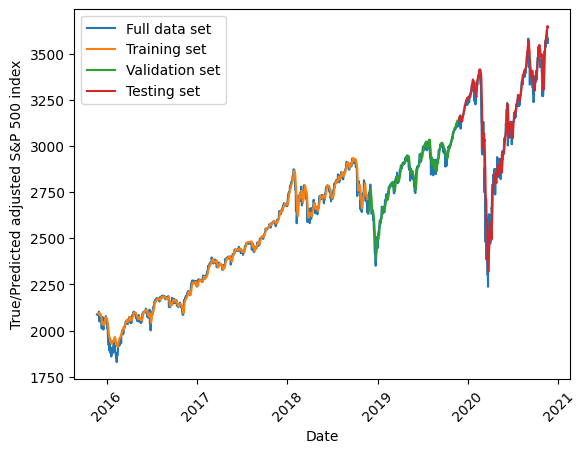

In [36]:
## visualize model prediction

plt.plot(stock, label = 'Full data set')
plt.plot(train_pred_plt, label = 'Training set')
plt.plot(val_pred_plt, label = 'Validation set')
plt.plot(test_pred_plt, label = 'Testing set')

plt.xlabel('Date')
plt.ylabel('True/Predicted adjusted S&P 500 index')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation = 45)
plt.legend()

# plt.xlim([date(2019, 1, 1), date(2022, 1, 1)])

plt.show()

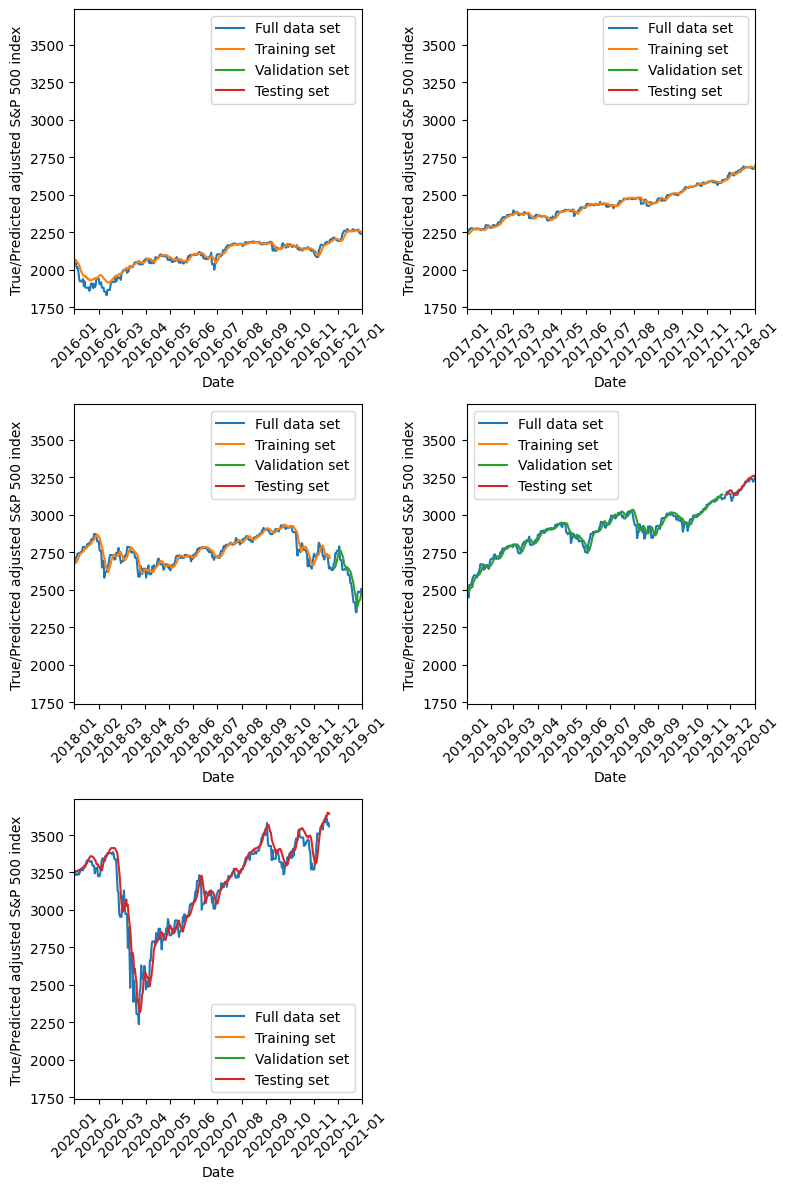

In [37]:
## plot by year

yrs = list(range(2016, 2021))

plt.figure(figsize = (8, 12))

for i, yr in enumerate(yrs, 1):
    
    plt.subplot(3, 2, i)
    plt.plot(stock, label = 'Full data set')
    plt.plot(train_pred_plt, label = 'Training set')
    plt.plot(val_pred_plt, label = 'Validation set')
    plt.plot(test_pred_plt, label = 'Testing set')

    plt.xlabel('Date')
    plt.ylabel('True/Predicted adjusted S&P 500 index')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation = 45)
    plt.legend()
    plt.xlim([date(yr, 1, 1), date(yr + 1, 1, 1)])
    
plt.tight_layout()